# Running Palace Simulations: Mach Zehnder Modulator

[Palace](https://awslabs.github.io/palace/) is an open-source 3D electromagnetic simulator supporting eigenmode, driven (S-parameter), and electrostatic simulations. This notebook demonstrates using the `gsim.palace` API to run a driven simulation on a Mach Zehnder Modulator.

**Requirements:**

- [GDSFactory+](https://gdsfactory.com) account for cloud simulation

### Construct custom layer stack

In [30]:
from pathlib import Path
import gdsfactory as gf
from gsim.common import LayerStack, Layer

CONDUCTOR_THICKNESS=1
QUARTZ_THICKNESS=300
SILICON_DIOXIDE_THICKNESS=2
TFLN_BOTTOM_THICKNESS=0.6
TFLN_TOP_THICKNESS=0.3
AIR_THICKNESS=300

quartz_layer = Layer(
    name="quartz_substrate",
    gds_layer=(1, 0),
    zmin=0,
    zmax=QUARTZ_THICKNESS,
    thickness=QUARTZ_THICKNESS,
    material="quartz",
    layer_type="dielectric",
    mesh_resolution="coarse"
)
siO2_layer = Layer(
    name="silicon_dioxide",
    gds_layer=(2, 0),
    zmin=quartz_layer.zmax,
    zmax=quartz_layer.zmax+SILICON_DIOXIDE_THICKNESS,
    thickness=SILICON_DIOXIDE_THICKNESS,
    material="SiO2",
    layer_type="dielectric",
    mesh_resolution="coarse"
)

tfln_base_layer = Layer(
    name="tfln_base",
    gds_layer=(3, 0),
    zmin=siO2_layer.zmax,
    zmax=siO2_layer.zmax+TFLN_BOTTOM_THICKNESS,
    thickness=TFLN_BOTTOM_THICKNESS,
    material="tfln",
    layer_type="dielectric",
    mesh_resolution="coarse"
)
tfln_rib_layer = Layer(
    name="tfln_rib",
    gds_layer=(4, 0),
    zmin=tfln_base_layer.zmax,
    zmax=tfln_base_layer.zmax+TFLN_TOP_THICKNESS,
    thickness=TFLN_TOP_THICKNESS,
    material="tfln",
    layer_type="conductor",
    mesh_resolution="coarse"
)
gold_layer = Layer(
    name="gold",
    gds_layer=(5, 0),
    zmin=tfln_base_layer.zmax,
    zmax=tfln_base_layer.zmax+CONDUCTOR_THICKNESS,
    thickness=CONDUCTOR_THICKNESS,
    material="gold",
    layer_type="conductor",
    mesh_resolution="fine"
)
layers = [quartz_layer, siO2_layer, tfln_base_layer, tfln_rib_layer, gold_layer]

# Create layer stack and export to YAML
layer_stack = LayerStack.from_layer_list(layers)
stack_filename = "mzm_stack.yaml"
layer_stack.to_yaml(Path(stack_filename))

"version: '1.0'\npdk: unknown\nunits: um\nmaterials:\n  quartz:\n    type: dielectric\n    permittivity: 4.5\n  SiO2:\n    type: dielectric\n    permittivity: 4.1\n    loss_tangent: 0.0\n    refractive_index: 1.44\n  tfln:\n    type: dielectric\n    permittivity: 44.0\n  gold:\n    type: conductor\n    conductivity: 41000000.0\nlayers:\n  quartz_substrate:\n    gds_layer:\n    - 1\n    - 0\n    zmin: 0.0\n    zmax: 300.0\n    thickness: 300.0\n    material: quartz\n    type: dielectric\n    mesh_resolution: coarse\n  silicon_dioxide:\n    gds_layer:\n    - 2\n    - 0\n    zmin: 300.0\n    zmax: 302.0\n    thickness: 2.0\n    material: SiO2\n    type: dielectric\n    mesh_resolution: coarse\n  tfln_base:\n    gds_layer:\n    - 3\n    - 0\n    zmin: 302.0\n    zmax: 302.6\n    thickness: 0.6\n    material: tfln\n    type: dielectric\n    mesh_resolution: coarse\n  tfln_rib:\n    gds_layer:\n    - 4\n    - 0\n    zmin: 302.6\n    zmax: 302.9\n    thickness: 0.3\n    material: tfln\n    ty

### Generate layout for MZM

Polycount before=83
Polycount after=1
Polycount before=42
Polycount after=1
Polycount before=42
Polycount after=1


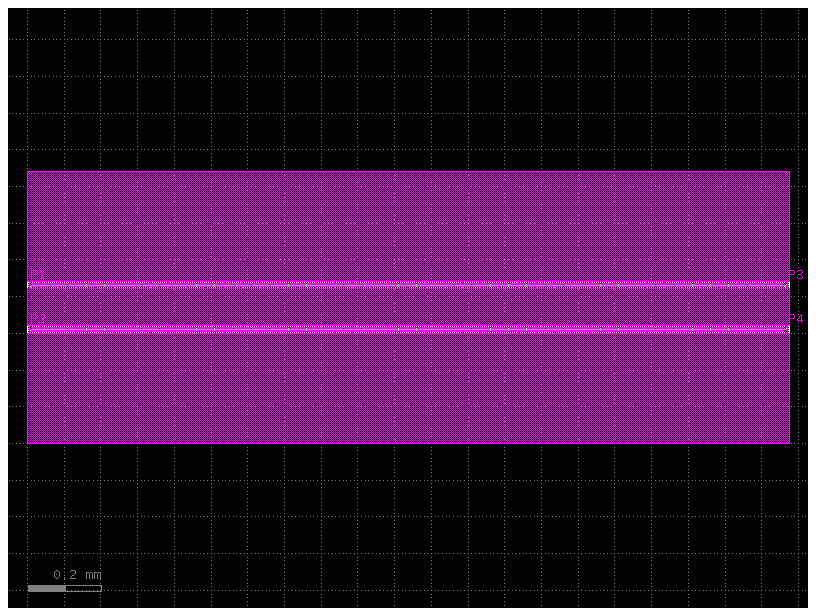

In [ ]:
import klayout.db as kdb

gf.gpdk.PDK.activate()

def t_shape_dpoly(w1: float, w2: float, h1: float, h2: float) -> kdb.DPolygon:
    w3 = (w2 - w1) / 2
    return kdb.DPolygon([
        kdb.DPoint(-w1 / 2, 0),
        kdb.DPoint( w1 / 2, 0),
        kdb.DPoint( w1 / 2, h1),
        kdb.DPoint( w1 / 2 + w3, h1),
        kdb.DPoint( w1 / 2 + w3, h1 + h2),
        kdb.DPoint(-w1 / 2 - w3, h1 + h2),
        kdb.DPoint(-w1 / 2 - w3, h1),
        kdb.DPoint(-w1 / 2, h1),
    ])

def _insert_region_into_component(comp: gf.Component, region: kdb.Region, layer: tuple[int, int]):
    li = comp.kcl.layer(*layer)
    comp.kdb_cell.shapes(li).insert(region)

def cpw_conductor(
    layer: tuple[int, int],
    board_length: float,
    board_width: float,
    gap: float,
    trace_width: float,
    ground_width: float,
    w1: float,
    w2: float,
    h1: float,
    h2: float,
    t_spacing: float,
) -> gf.Component:
    
    comp = gf.Component()
    dbu = comp.kcl.dbu

    midwidth = board_width / 2
    number_of_ts = int(board_length / (w2 + t_spacing))
    leftover_length = board_length - number_of_ts * (w2 + t_spacing)
    x_start = leftover_length / 2

    def dpoly_to_ipoly(dp: kdb.DPolygon) -> kdb.Polygon:
        return dp.to_itype(dbu)

    trace = kdb.Region()

    rect_trace = kdb.DPolygon([
        kdb.DPoint(0, midwidth - trace_width / 2),
        kdb.DPoint(board_length, midwidth - trace_width / 2),
        kdb.DPoint(board_length, midwidth + trace_width / 2),
        kdb.DPoint(0, midwidth + trace_width / 2),
    ])
    trace.insert(dpoly_to_ipoly(rect_trace))

    for i in range(number_of_ts):
        dp = t_shape_dpoly(w1, w2, h1, h2)
        dp = dp.transformed(kdb.DTrans(x_start + i * (w2 + t_spacing) + w2 / 2,
                                       midwidth + trace_width / 2))
        trace.insert(dpoly_to_ipoly(dp))

    for i in range(number_of_ts):
        dp = t_shape_dpoly(w1, w2, h1, h2)
        dp = dp.transformed(kdb.DTrans(kdb.DTrans.R180))
        dp = dp.transformed(kdb.DTrans(x_start + i * (w2 + t_spacing) + w2 / 2,
                                       midwidth - trace_width / 2))
        trace.insert(dpoly_to_ipoly(dp))

    trace.merge()
    _insert_region_into_component(comp, trace, layer)

    ground_lower = kdb.Region()
    rect_gL = kdb.DPolygon([
        kdb.DPoint(0, midwidth - trace_width / 2 - gap),
        kdb.DPoint(0, midwidth - trace_width / 2 - gap - ground_width),
        kdb.DPoint(board_length, midwidth - trace_width / 2 - gap - ground_width),
        kdb.DPoint(board_length, midwidth - trace_width / 2 - gap),
    ])
    ground_lower.insert(dpoly_to_ipoly(rect_gL))

    for i in range(number_of_ts):
        dp = t_shape_dpoly(w1, w2, h1, h2)
        dp = dp.transformed(kdb.DTrans(x_start + i * (w2 + t_spacing) + w2 / 2,
                                       midwidth - trace_width / 2 - gap))
        ground_lower.insert(dpoly_to_ipoly(dp))

    ground_lower.merge()
    _insert_region_into_component(comp, ground_lower, layer)

    ground_upper = kdb.Region()
    rect_gU = kdb.DPolygon([
        kdb.DPoint(0, midwidth + trace_width / 2 + gap),
        kdb.DPoint(0, midwidth + trace_width / 2 + gap + ground_width),
        kdb.DPoint(board_length, midwidth + trace_width / 2 + gap + ground_width),
        kdb.DPoint(board_length, midwidth + trace_width / 2 + gap),
    ])
    ground_upper.insert(dpoly_to_ipoly(rect_gU))

    for i in range(number_of_ts):
        dp = t_shape_dpoly(w1, w2, h1, h2)
        dp = dp.transformed(kdb.DTrans(kdb.DTrans.R180))
        dp = dp.transformed(kdb.DTrans(x_start + i * (w2 + t_spacing) + w2 / 2,
                                       midwidth + trace_width / 2 + gap))
        ground_upper.insert(dpoly_to_ipoly(dp))

    ground_upper.merge()
    _insert_region_into_component(comp, ground_upper, layer)

    return comp

def rib(
    layer: tuple[int, int],
    board_width: float,
    board_length: float,
    gap: float,
    trace_width: float,
    opt_width: float,
    port_length: float
) -> gf.Component:
    rib_comp = gf.Component()
    midwidth = board_width / 2
    center = midwidth + trace_width / 2 + gap / 2
    offset = port_length + 1
    rib_comp.add_polygon(
        [
            (offset, center - opt_width / 2),
            (board_length-offset, center - opt_width / 2),
            (board_length-offset, center + opt_width / 2),
            (offset, center + opt_width / 2),
        ],
        layer=layer,
    )
    center = midwidth - trace_width / 2 - gap / 2
    rib_comp.add_polygon(
        [
            (offset, center - opt_width / 2),
            (board_length-offset, center - opt_width / 2),
            (board_length-offset, center + opt_width / 2),
            (offset, center + opt_width / 2),
        ],
        layer=layer,
    )
    return rib_comp

def mzm_cpw(
    quartz_layer: Layer,
    siO2_layer: Layer,
    tfln_base_layer: Layer,
    tfln_rib_layer: Layer,
    conductor_layer: Layer,
    board_width: float,
    board_length: float,
    gap: float,
    trace_width: float,
    ground_width: float,
    rib_width: float,
    t_w1: float,
    t_w2: float,
    t_h1: float,
    t_h2: float,
    t_spacing: float,
    port_length: float
) -> gf.Component:
    comp = gf.Component()
    comp.add_polygon(
        [
            (0, 0),
            (board_length, 0),
            (board_length, board_width),
            (0, board_width),
        ],
        layer=quartz_layer.gds_layer,
    )
    comp.add_polygon(
        [
            (0, 0),
            (board_length, 0),
            (board_length, board_width),
            (0, board_width),
        ],
        layer=siO2_layer.gds_layer,
    )
    comp.add_polygon(
        [
            (0, 0),
            (board_length, 0),
            (board_length, board_width),
            (0, board_width),
        ],
        layer=tfln_base_layer.gds_layer,
    )

    cpw_comp = cpw_conductor(
        layer=conductor_layer.gds_layer,
        board_length=board_length,
        board_width=board_width,
        gap=gap,
        trace_width=trace_width,
        ground_width=ground_width,
        w1=t_w1,
        w2=t_w2,
        h1=t_h1,
        h2=t_h2,
        t_spacing=t_spacing
    )
    comp.add_ref(cpw_comp)

    rib_comp = rib(
        layer=tfln_rib_layer.gds_layer,
        board_width=board_width,
        board_length=board_length,
        gap=gap,
        trace_width=trace_width,
        opt_width=rib_width,
        port_length=port_length
    )
    comp.add_ref(rib_comp)

    midwidth = board_width / 2

    comp.add_port(
        name="P1",
        center=(port_length/2, midwidth + trace_width / 2 + gap / 2),
        width=gap,
        orientation=0,
        port_type="electrical",
        layer=conductor_layer.gds_layer,
    )
    comp.add_port(
        name="P2",
        center=(port_length/2, midwidth - trace_width / 2 - gap / 2),
        width=gap,
        orientation=0,
        port_type="electrical",
        layer=conductor_layer.gds_layer,
    )
    comp.add_port(
        name="P3",
        center=(board_length-port_length/2, midwidth + trace_width / 2 + gap / 2),
        width=gap,
        orientation=180,
        port_type="electrical",
        layer=conductor_layer.gds_layer,
    )
    comp.add_port(
        name="P4",
        center=(board_length-port_length/2, midwidth - trace_width / 2 - gap / 2),
        width=gap,
        orientation=180,
        port_type="electrical",
        layer=conductor_layer.gds_layer,
    )
    return comp

# T-shape parameters
w1=2 # width of the stem of the T
w2=45 # width of the T top bar
h1=6 # height of the stem of the T
h2=2 # height of the T top bar
spacing=5 # spacing between Ts
trace_width=100
ground_width=300
MZM_CPW_GAP = 5+2*(h1+h2) # gap + 2*(h1+h2) to ensure ports are outside of the T shapes
board_width = trace_width + 2*ground_width + 2*MZM_CPW_GAP
PORT_LENGTH = MZM_CPW_GAP/2 # length of the port to ensure it's outside of the T shapes

mzm_cpw_comp = mzm_cpw(
    quartz_layer=quartz_layer,
    siO2_layer=siO2_layer,
    tfln_base_layer=tfln_base_layer,
    tfln_rib_layer=tfln_rib_layer,
    conductor_layer=gold_layer,
    board_length=2075,
    board_width=board_width,
    gap=MZM_CPW_GAP,
    trace_width=trace_width,
    ground_width=ground_width,
    rib_width=1,
    t_w1=w1,
    t_w2=w2,
    t_h1=h1,
    t_h2=h2,
    t_spacing=spacing,
    port_length=PORT_LENGTH
)

# Draw and plot MZM CPW component
_mzm_cpw_comp = mzm_cpw_comp.copy()
_mzm_cpw_comp.draw_ports()
_mzm_cpw_comp.plot()


### Configure and run simulation with DrivenSim

In [32]:
from gsim.palace import DrivenSim

# Create simulation object
sim = DrivenSim()

# Set output directory
sim.set_output_dir("./palace-sim-mzm")

# Set the component geometry
sim.set_geometry(mzm_cpw_comp)

# Configure layer stack from active PDK
sim.set_stack(yaml_path=Path(stack_filename))

# Configure via ports (Metal1 ground plane to TopMetal2 signal)
# Configure left CPW port (P1 lower, P2 upper)
sim.add_cpw_port("P2", "P1", layer="gold", length=PORT_LENGTH)

# Configure right CPW port (P4 lower, P3 upper)
sim.add_cpw_port("P3", "P4", layer="gold", length=PORT_LENGTH)

# Configure driven simulation (frequency sweep for S-parameters)
sim.set_driven(fmin=1e9, fmax=100e9, num_points=40)

# Validate configuration
print(sim.validate_config())

Validation: PASSED


In [33]:
# Generate mesh (presets: "coarse", "default", "fine")
sim.mesh(preset="coarse", margin=15, air_above=50)

/home/eduguerra/gsim/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3701: UserWarning: Preset 'coarse' values overridden by: margin=15, air_above=50
  exec(code_obj, self.user_global_ns, self.user_ns)


Mesh Summary
Dimensions: 2205.0 x 872.0 x 402.6 µm
Nodes:      23,925
Elements:   201,644
Tetrahedra: 138,106
Edge length: 0.30 - 474.02 µm
Quality:    0.251 (min: 0.000)
SICN:       0.290 (all valid)
----------------------------------------
Volumes (4):
  - tfln [1]
  - SiO2 [2]
  - quartz [3]
  - airbox [4]
Surfaces (9):
  - tfln_rib_xy [5]
  - tfln_rib_z [6]
  - gold_xy [7]
  - gold_z [8]
  - P1_E0 [9]
  - P1_E1 [10]
  - P2_E0 [11]
  - P2_E1 [12]
  - Absorbing_boundary [13]
----------------------------------------
Mesh:   palace-sim-mzm/palace.msh

In [34]:
# Interactive
#sim.plot_mesh(show_groups=["gold_xy", "gold_z", "P1_E0", "P1_E1", "P2_E0", "P2_E1"], interactive=True)
sim.plot_mesh(interactive=True)

Widget(value='<iframe src="http://localhost:45329/index.html?ui=P_0x7e897555fad0_6&reconnect=auto" class="pyvi…

In [35]:
# Generate Palace config file
sim.write_config()

PosixPath('palace-sim-mzm/config.json')

### Run simulation on GDSFactory+ Cloud

In [ ]:
# Run simulation on GDSFactory+ cloud
results = sim.run()

Uploading simulation... done
Job started: palace-e44f9db5
Created: 16:54:03 | Now: 17:44:50 | Status: running

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(results["port-S.csv"])
df.columns = df.columns.str.strip()  # Remove whitespace from column names

freq = df["f (GHz)"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Magnitude plot
ax1.plot(freq, df["|S[1][1]| (dB)"], marker=".", label="S11")
ax1.plot(freq, df["|S[2][1]| (dB)"], marker=".", label="S21")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("S-Parameters")
ax1.legend()
ax1.grid(True)

# Phase plot
ax2.plot(freq, df["arg(S[1][1]) (deg.)"], marker=".", label="S11")
ax2.plot(freq, df["arg(S[2][1]) (deg.)"], marker=".", label="S21")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase (deg)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()